In [200]:
#Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Scikit Learn
from sklearn.preprocessing import StandardScaler

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image

## DATA PREP

### Load and Split

In [188]:
# Load data
trainDataNP = np.load("fashion_train.npy")
testDataNP = np.load("fashion_test.npy")

# Split data into X and y arrays
X_train = trainDataNP[:, :-1]
y_train = trainDataNP[:, -1]
X_test = testDataNP[:, :-1]
y_test = testDataNP[:, -1]

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Transform to Tensor

In [210]:
# Define superclass to handle own input datasets
class CustomDataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):

        # Convert NumPy array to PIL Image
        image = Image.fromarray(self.X[idx])
        # image = Image.fromarray((self.X[idx] * 255).astype(np.uint8))  # Convert to [0, 255]

        # Collect image and label in sample dict
        sample = {'image': image, 'label': int(self.y[idx])}

        # Use transformer
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

# Define transformer
transformer = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

# Create dataset
train = CustomDataset(X_train_scaled, y_train, transform = transformer)

# Define batch size
batch_size = 64

# Split train data into train and validation
train, validation = torch.utils.data.random_split(train, [int(len(train) * .8), int(len(train) * .2)])

# Create data loaders
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(validation, batch_size = batch_size, shuffle = True)

## CNN

### Build Model

In [211]:
# Create custom CNN model
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()

        # # First convolutional layer: 1 input channel (greyscale), 6 output channels, 3x3 kernel
        # self.conv1 = nn.Conv2d(1, 32, kernel_size = 3)

        # # Second convolutional layer: 32 input channel, 32 output channels, 3x3 kernel
        # self.conv2 = nn.Conv2d(32, 32, kernel_size = 3)

        # # First pooling layer
        # self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # # Third convolutional layer: 32, input channels, 64 output channels, 3x3 kernel
        # self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)

        # # Third convolutional layer: 64, input channels, 64 output channels, 3x3 kernel
        # self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)

        # # Second pooling layer
        # self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # # Fully connected layers
        # # Flatten before passing to fully connected layers
        # self.fc_input_size = self.calculate_fc_input_size()
        # self.fc1 = nn.Linear(self.fc_input_size, 128)
        # self.relu1 = nn.ReLU()
        # self.fc2 = nn.Linear(128, n_classes)

        # First convolutional layer: 1 input channel, 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size = 5, padding = 2)
        self.sigmoid1 = nn.Sigmoid()
        self.pool1 = nn.AvgPool2d(kernel_size = 2, stride = 2)

        # Second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, kernel_size = 5)
        self.sigmoid2 = nn.Sigmoid()
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)

        # Fully connected layers
        # Flatten before passing to fully connected layers
        self.fc_input_size = self.calculate_fc_input_size()
        self.fc1 = nn.Linear(self.fc_input_size, 120)
        self.sigmoid3 = nn.Sigmoid()
        self.fc2 = nn.Linear(120, 84)
        self.sigmoid4 = nn.Sigmoid()
        self.fc3 = nn.Linear(84, n_classes) # Output layer, 10 classes (digits 0 through 9)

    def calculate_fc_input_size(self):
        
        # # Dummy input to calculate the size after convolutional layers
        # x = torch.randn(1, 1, 28, 28)
        # x = self.conv1(x)
        # x = self.conv2(x)
        # x = self.pool1(x)
        # x = self.conv3(x)
        # x = self.conv4(x)
        # x = self.pool2(x)

        # First convolutional block
        x = torch.randn(1, 1, 28, 28)
        x = self.conv1(x)
        x = self.sigmoid1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.sigmoid2(x)
        x = self.pool2(x)

        # Flatten before passing to fully connected layers
        return x.view(1, -1).size(1)

    def forward(self, x):

        # # First convolutional block
        # x = self.conv1(x)
        # x = self.conv2(x)
        # x = self.pool1(x)
        
        # # Second convolutional block
        # x = self.conv3(x)
        # x = self.conv4(x)
        # x = self.pool2(x)
        
        # # Flatten before passing to fully connected layers
        # x = x.reshape(x.size(0), -1)
        
        # # Fully connected layers
        # x = self.fc1(x)
        # x = self.relu1(x)
        # x = self.fc2(x)

        # First convolutional block
        x = self.conv1(x)
        x = self.sigmoid1(x)
        x = self.pool1(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.sigmoid2(x)
        x = self.pool2(x)

        # Flatten before passing to fully connected layers
        x = x.reshape(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.sigmoid3(x)
        x = self.fc2(x)
        x = self.sigmoid4(x)
        x = self.fc3(x)

        return x

### Instantiate Model

In [212]:
# Define variables
n_classes = len(np.unique(y_train))
alpha = .01 # .001 # Learning rate

# Instantiate model
model = CNN(n_classes = n_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = alpha, weight_decay = 0.005, momentum = 0.9)  

# Defnie total_step to ease iteration through batches
total_step = len(train_loader)

### Train Model

In [213]:
# Define number of epochs
n_epochs = 100

# Create device object to choose whether to run training on CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to the device
model.to(device)

# Define lists to store training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []

# # Use defined number of epochs to determine amount of iterations to train model on 
# for epoch in range(1, n_epochs + 1):

#     # Load in the data in batches using dataloader object
#     for batch in train_loader:

#         # Extract images and labels from the batch
#         images, labels = batch['image'], batch['label']

#         # Pass image and label tensors to device
#         images = images.to(device)
#         labels = labels.to(device)

#         # Run forward pass
#         output = model(images)
#         loss = criterion(output, labels)

#         # Run backwards pass and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # Print results
#     print(f'Epoch {epoch} / {n_epochs}, Loss: {loss.item()}')

# Create training loop
for epoch in range(n_epochs):
    model.train()
    running_loss = .0

    for batch in train_loader:

        # Extract images and labels from the batch and move to device
        imgs, labels = batch['image'], batch['label']
        imgs, labels = imgs.to(device), labels.to(device)

        # Run model and collect loss
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = .0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:

            # Extract images and labels from the batch and move to device
            imgs, labels = batch['image'], batch['label']
            imgs, labels = imgs.to(device), labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy for the epoch
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = (correct/total) * 100
    val_accuracies.append(val_accuracy)

    # Print training and validation statistics
    print(f'Epoch {epoch + 1} / {n_epochs}, ',
          f'Train Loss: {train_loss:.4f}, ',
          f'Val Loss: {val_loss:.4f}, ',
          f'Val Accuracy: {val_accuracy:.2f}%')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x84 and 120x84)

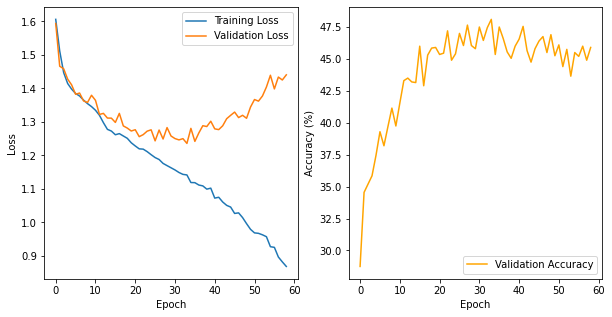

In [ ]:
# Plot training curves
plt.figure(figsize = (10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label = 'Validation Accuracy', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
# from lda import LDA
# MDA_4 = LDA(n_components = 4)

# X_projected_4 = MDA_4.fit_transform(X_train_scaled, y_train)
# X_t_projected_4 = MDA_4.transform(X_test_scaled)

In [ ]:
# cnn = MLPClassifier()
# cnn.fit(X_projected_4, y_train)

In [ ]:
# cnn.score(X_projected_4, y_train)

In [ ]:
# y_pred = cnn.predict(X_t_projected_4)

# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')

In [ ]:
# for n in range (1,10):
#     cnn = MLPClassifier()
#     scores = cross_val_score(cnn, X_train, y_train, cv=5)
#     print(n, round(np.mean(scores), 4), 'and', accuracy)